In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {w: i+1 for i, w in enumerate(chars)}
stoi['.'] = 0
itos = {i: w for w, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size, device='mps'):
    X = []
    Y = []
    for word in words:
        ctx = [0] * block_size
        for c in word + '.':
            X.append(ctx)
            Y.append(stoi[c])
            #print(''.join(itos[x] for x in ctx), '--->',c)
            ctx = ctx[1:] + [stoi[c]]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

import random
random.shuffle(words)
n1 = int(len(words) * .8)
n2 = int(len(words) * .9)

block_size = 3
Xtrain, Ytrain = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xtest, Ytest = build_dataset(words[n2:], block_size)

In [6]:
Xtrain.shape, Ytrain.shape

(torch.Size([182609, 3]), torch.Size([182609]))

In [7]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = torch.max(torch.abs(dt - t.grad)).item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} maxdiff: {maxdiff}')

# Network Setup

In [9]:
mps_device = torch.device('mps')

emb_dim = 10
mlp_dim = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), emb_dim), generator=g, device='mps')
# Layer 1
W1 = torch.randn((emb_dim * block_size, mlp_dim), generator=g, device='mps') * (5/3)/((emb_dim * block_size)**0.5)
b1 = torch.randn(mlp_dim, generator=g, device='mps') * 0.1
# Layer 2
W2 = torch.randn((mlp_dim, len(stoi)), generator=g, device='mps') * 0.1
b2 = torch.randn(len(stoi), generator=g, device='mps') * 0.1
# Batchnorm
bngain = torch.ones(mlp_dim, device='mps') * 0.1 + 1.0
bnbias = torch.zeros(mlp_dim, device='mps') * 0.1

params = [C, W1, b1, W2, b2, bngain, bnbias]

print("Model Params:", sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

Model Params: 4137


# Training

In [8]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtrain.shape[0], (n,))
Xb, Yb = Xtrain[ix], Ytrain[ix]

In [9]:
#-- embedding
emb = C[Xb]
embcat = emb.view((-1, emb_dim * block_size))

#-- linear layer
hprebn = embcat @ W1 + b1

#-- batch norm
bnmeani = 1/n * torch.sum(hprebn, 0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * torch.sum(bndiff2, 0, keepdim=True) # Bessel's correction (n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bnraw * bngain + bnbias
#-- Non-linear activation
h = torch.tanh(hpreact)
#-- Linear layer
logits = h @ W2 + b2
#-- Loss
logit_maxis = torch.max(logits, 1, keepdim=True).values
norm_logits = logits - logit_maxis
counts = torch.exp(norm_logits)
counts_sum = torch.sum(counts, 1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = torch.log(probs)
loss = -logprobs[range(n), Yb].mean()

#-- backprop
for p in params:
    p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, 
          norm_logits, logit_maxis, logits, h, hpreact, bnraw, 
          bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

      0/  50000: 3.3069


In [ ]:
#learning_rate = lrs[i]
lr = 0.1 if i < 100000 else 0.01
for p in params:
    p.data += -lr * p.grad

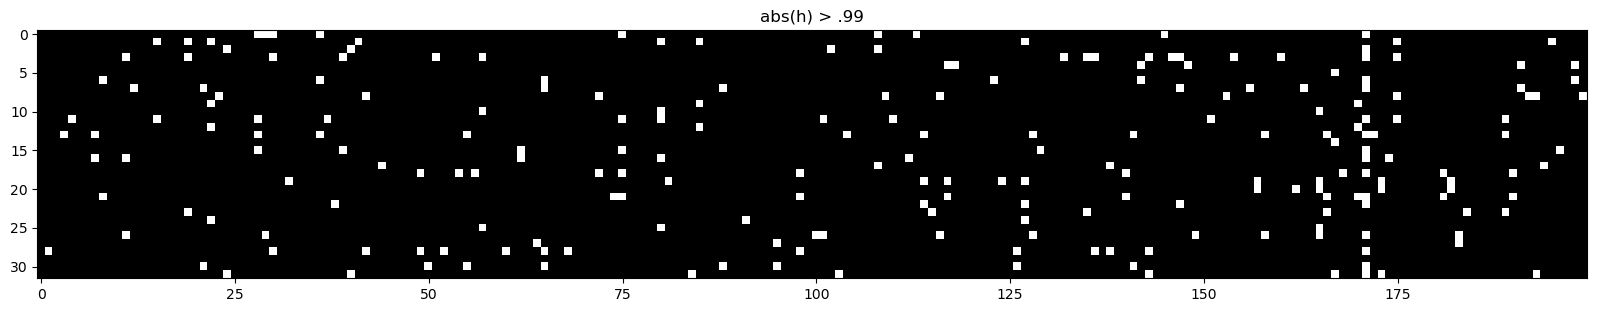

In [ ]:
plt.figure(figsize=(20, 10))
# plot abs(h) > .99 as image
plt.imshow(h.abs().cpu() > .99, cmap='gray', interpolation='nearest')
plt.title('abs(h) > .99');

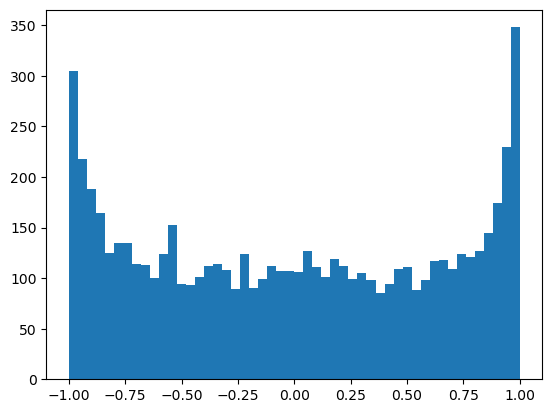

In [ ]:
plt.hist(h.view(-1).tolist(), bins=50);

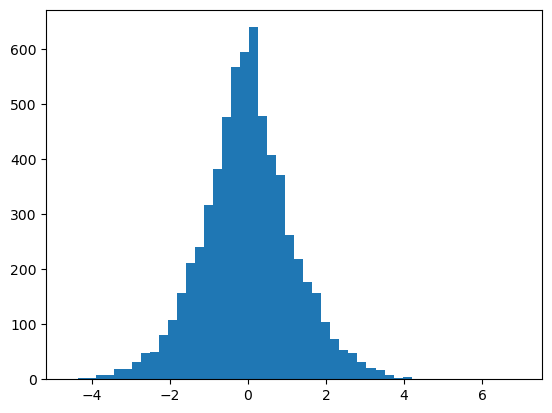

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

# Validation

In [ ]:
# calculate mean and std of training set
with torch.no_grad():
    emb = C[Xtrain]
    embcat = emb.view((-1, emb_dim * block_size))
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    embcat = emb.view((-1, emb_dim * block_size))
    hpreact = embcat @ W1 + b1
    hpreact = (hpreact - bnmean_running) / bnstd_running
    hpreact = hpreact * bngain + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

loss_train = split_loss('train')
print('train', loss_train)

loss_dev = split_loss('dev')
print('dev', loss_dev)

train tensor(2.2606, device='mps:0')
dev tensor(2.2899, device='mps:0')


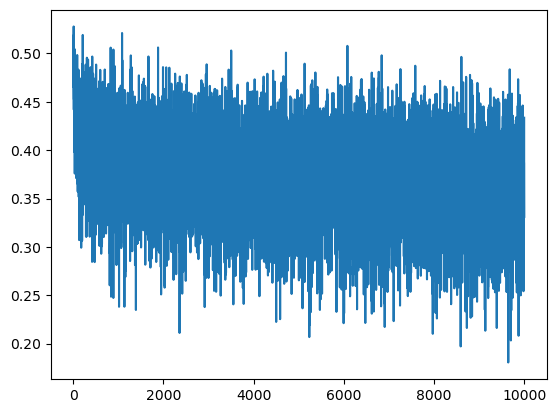

In [ ]:
plt.plot(stepi, lossi)

# Model Sampling

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      x = torch.tanh(x @ W1 + b1)
      logits = x @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

devis.
dayson.
katimruyalinea.
ciralitraide.
ramariah.
acie.
mile.
mari.
joerumaroiliana.
adaita.
hamighishlistyn.
dys.
rims.
dayrion.
rien.
kalana.
hum.
tie.
adderrismerrah.
dema.


# PyTorchify

In [106]:
class Linear:
    def __init__(self, fan_in, fan_out, device='cpu', bias=True):
        self.weight = torch.randn((fan_in, fan_out), device=device, generator=g) / fan_in**0.5
        self.b = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.b is None else [self.b])
    
class BatchNorm1d:
    def __init__(self, fan_in, eps=1e-5, momentum=0.1, device='cpu'):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(fan_in, device=device)
        self.beta = torch.zeros(fan_in, device=device)
        self.mean_running = torch.zeros(fan_in, device=device)
        self.var_running = torch.ones(fan_in, device=device)
        self.training = True

    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.mean_running
            var = self.var_running

        self.out = (x - mean) / (var + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.mean_running = self.momentum * self.mean_running + (1 - self.momentum) * mean
                self.var_running = self.momentum * self.var_running + (1 - self.momentum) * var

        return self.out 
        
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [107]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

vocab_size = len(stoi)
#device = 'mps'
device = 'mps'

#BatchNorm(n_hidden, device=device)

C = torch.randn((vocab_size, n_embd), generator=g, device=device)
layers = [
    Linear(n_embd * block_size, n_hidden, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, n_hidden, device=device),
    BatchNorm1d(n_hidden, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, device=device),
    BatchNorm1d(vocab_size, device=device),
]

init_gain = 5/3
with torch.no_grad():
  # last layer: make less confident
  #layers[-1].W *= 0.1
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= init_gain

params = [C] + [p for layer in layers for p in layer.parameters()]
print("Model Params:", sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

Model Params: 47551


In [100]:
lri = []
lossi = []
stepi = []
ud = []

In [101]:
batch_size = 32
max_steps = 5000

for i in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size,))

    #-- embedding
    emb = C[Xtrain[ix]]
    embcat = emb.view((-1, n_embd * block_size))

    #-- layers
    x = embcat
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Ytrain[ix])

    #-- backprop
    for l in layers:
        l.out.retain_grad()
    for p in params:
        p.grad = None
    loss.backward()

    #learning_rate = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log().item() for p in params])

    if i >= 1:
        break

print(loss)

      0/   5000: 3.3071
tensor(3.2852, device='mps:0', grad_fn=<NllLossBackward0>)


Check activation output and gradient distributions. Shouldn't be too saturated on init to allow to train.

layer 2 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.38%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

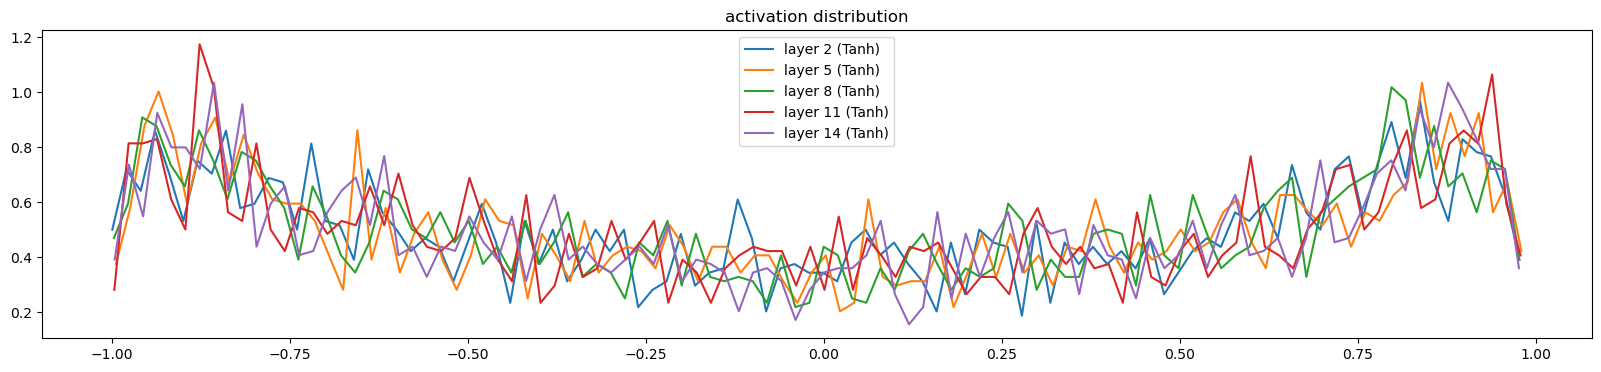

In [102]:
# plot Tanh activation
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 6.845622e-04
layer 5 (      Tanh): mean +0.000000, std 6.228024e-04
layer 8 (      Tanh): mean +0.000000, std 5.531800e-04
layer 11 (      Tanh): mean -0.000000, std 4.915540e-04
layer 14 (      Tanh): mean -0.000000, std 4.559777e-04


Text(0.5, 1.0, 'gradient distribution')

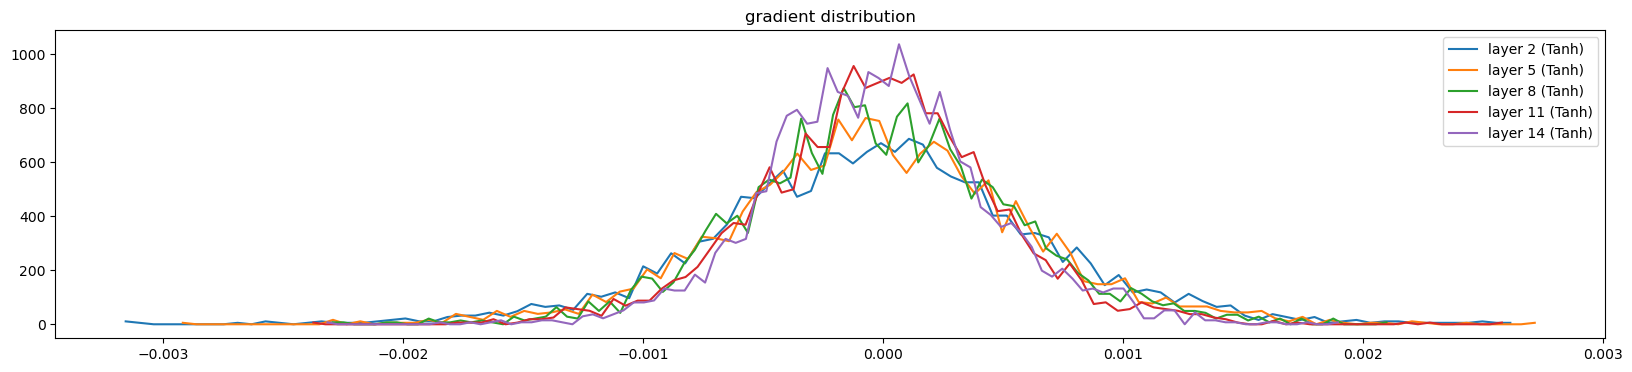

In [103]:
# plot Tanh activation
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')

Data ratio describes the rate data will change by the gradient.

Layers should learn a similar rates.

weight torch.Size([27, 10]) | mean +0.000000 | std 1.803254e-03 | grad:data ratio 1.903384e-03
weight torch.Size([30, 100]) | mean +0.000023 | std 1.486487e-03 | grad:data ratio 4.805567e-03
weight torch.Size([100, 100]) | mean -0.000012 | std 1.343851e-03 | grad:data ratio 7.993592e-03
weight torch.Size([100, 100]) | mean -0.000009 | std 1.362113e-03 | grad:data ratio 8.051516e-03
weight torch.Size([100, 100]) | mean +0.000012 | std 1.134558e-03 | grad:data ratio 6.857571e-03
weight torch.Size([100, 100]) | mean -0.000002 | std 9.564626e-04 | grad:data ratio 5.766388e-03
weight torch.Size([100, 27]) | mean +0.000005 | std 1.577071e-03 | grad:data ratio 9.302912e-03


Text(0.5, 1.0, 'gradient distribution')

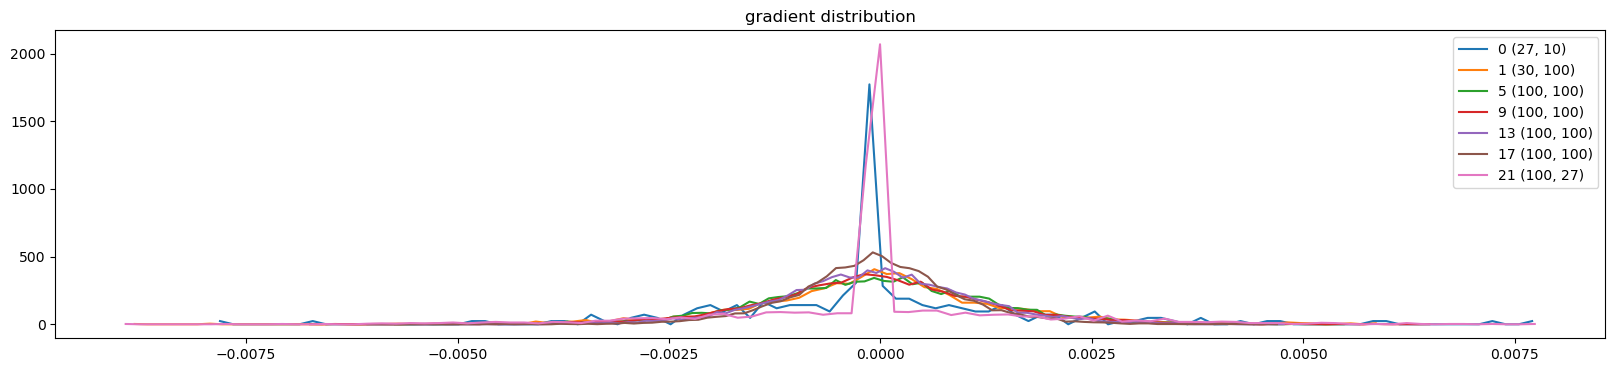

In [104]:
# plot Tanh activation
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (p.shape, t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('gradient distribution')

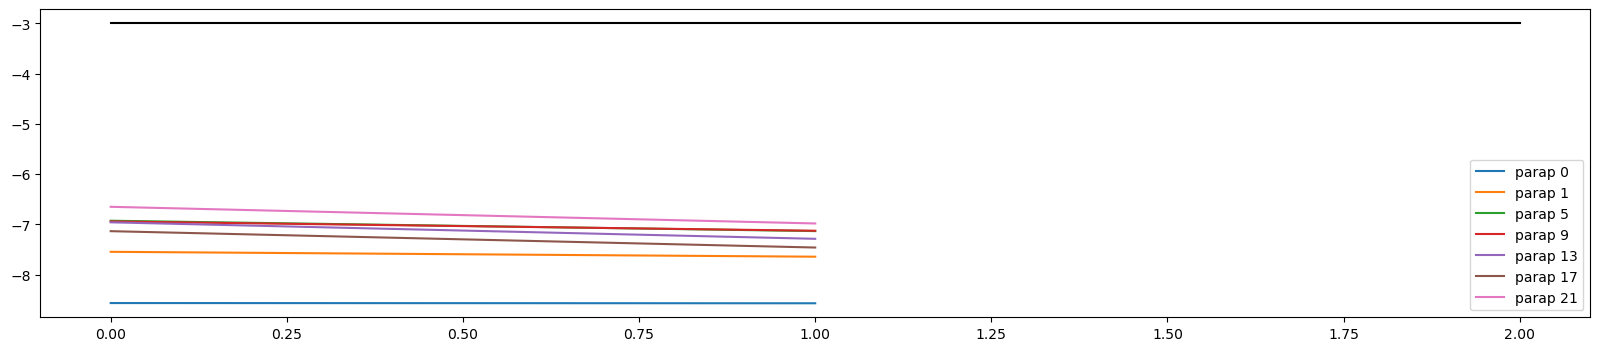

In [105]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(params):
    if p.dim() == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'parap {i}')
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)